# LSTM on real DNA sequences

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data pre-processing

In [3]:
"""intr_coords = pd.read_csv('Akey_intr_coords.bed', header = None, sep = "\t")
intr_coords.head()"""

'intr_coords = pd.read_csv(\'Akey_intr_coords.bed\', header = None, sep = "\t")\nintr_coords.head()'

In [4]:
#intr_lengths = intr_coords.iloc[:, 2]-intr_coords.iloc[:, 1]

In [5]:
#print(stats.describe(intr_lengths))

In [6]:
#!zcat hg19.fa.gz | bgzip -c > hg19.fa.bgz

In [7]:
"""a = 0
with open('hg19_intr_regions.fa', 'a') as fp:
    for i in range(intr_coords.shape[0]):
        coord = str(str(intr_coords.iloc[i, 0]) + ':' 
                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')"""

"a = 0\nwith open('hg19_intr_regions.fa', 'a') as fp:\n    for i in range(intr_coords.shape[0]):\n        coord = str(str(intr_coords.iloc[i, 0]) + ':' \n                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))\n        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')"

In [8]:
"""chr_sizes = pd.read_csv("hg19.fa.bgz.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)
chr_sizes.head()"""

'chr_sizes = pd.read_csv("hg19.fa.bgz.fai", header = None, sep = "\t")\nchr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)\nchr_sizes.head()'

In [9]:
"""chr_list = []
start_list = []
end_list = []
intr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])
a = 0
for i in range(intr_coords.shape[0]):
    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))
        reg_end = reg_start + intr_lengths[i]
        for j in range(chr_df.shape[0]):
            b1 = chr_df.iloc[j,1]
            b2 = chr_df.iloc[j,2]
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or \
            (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(intr_coords.iloc[i,0])
    start_list.append(reg_start)
    end_list.append(reg_end)
    a = a + 1
    if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')
depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
depl_coords.to_csv("Akey_depl_coords.bed", index = False, header = False, sep = "\t")
depl_coords.head()"""

'chr_list = []\nstart_list = []\nend_list = []\nintr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])\na = 0\nfor i in range(intr_coords.shape[0]):\n    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]\n    overlap = True\n    while overlap == True:\n        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))\n        reg_end = reg_start + intr_lengths[i]\n        for j in range(chr_df.shape[0]):\n            b1 = chr_df.iloc[j,1]\n            b2 = chr_df.iloc[j,2]\n            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or             (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):\n                overlap = True\n                break\n            else:\n                overlap = False\n    chr_list.append(intr_coords.iloc[i,0])\n    start_list.append(reg_start)\n    end_list.append(reg_end)\n    a = a + 1\n    if a%10000 == 0:\n            print(\'Fini

In [10]:
#depl_coords = pd.read_csv("Akey_depl_coords.bed", sep = "\t")

In [11]:
#!bedtools intersect -a Akey_intr_coords.bed -b Akey_depl_coords.bed | wc -l

In [12]:
"""a = 0
with open('hg19_depl_regions.fa', 'a') as fp:
    for i in range(depl_coords.shape[0]):
        coord = str(str(depl_coords.iloc[i, 0]) + ':' 
                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal ancestry depleted regions')"""

"a = 0\nwith open('hg19_depl_regions.fa', 'a') as fp:\n    for i in range(depl_coords.shape[0]):\n        coord = str(str(depl_coords.iloc[i, 0]) + ':' \n                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))\n        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' Neanderthal ancestry depleted regions')"

In [13]:
#!grep -c N hg19_intr_regions.fa

In [14]:
#!grep -c N hg19_depl_regions.fa

In [15]:
"""intr_file = 'hg19_intr_regions.fa'
depl_file = 'hg19_depl_regions.fa'
a = 0
i = 0
with open('hg19_intr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:
    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
        upper_intr = intr.seq.upper()
        upper_depl = depl.seq.upper()
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):
            intr.seq = upper_intr
            SeqIO.write(intr, intr_out, 'fasta')
            depl.seq = upper_depl
            SeqIO.write(depl, depl_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')"""

"intr_file = 'hg19_intr_regions.fa'\ndepl_file = 'hg19_depl_regions.fa'\na = 0\ni = 0\nwith open('hg19_intr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:\n    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):\n        upper_intr = intr.seq.upper()\n        upper_depl = depl.seq.upper()\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' entries')\n        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):\n            intr.seq = upper_intr\n            SeqIO.write(intr, intr_out, 'fasta')\n            depl.seq = upper_depl\n            SeqIO.write(depl, depl_out, 'fasta')\n            i = i + 1\n        else:\n            continue\nprint('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')"

In [16]:
#!grep -c N hg19_intr_regions.fa

In [17]:
#!grep -c N hg19_depl_regions.fa

## Data preparation for the LSTM

In [3]:
intr_file = '../data/hg19_intr_clean.fa'
depl_file = '../data/hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    for j in range(n_jumps):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 10
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [4]:
print(intr_texts[0:2])
print(depl_texts[0:2])

['GGATGCCCTC GATGCCCTCA ATGCCCTCAA TGCCCTCAAT GCCCTCAATG CCCTCAATGG CCTCAATGGC CTCAATGGCA TCAATGGCAG CAATGGCAGC AATGGCAGCA ATGGCAGCAG TGGCAGCAGC GGCAGCAGCC GCAGCAGCCC CAGCAGCCCA AGCAGCCCAT GCAGCCCATC CAGCCCATCT AGCCCATCTC GCCCATCTCT CCCATCTCTG CCATCTCTGG CATCTCTGGG ATCTCTGGGC TCTCTGGGCA CTCTGGGCAC TCTGGGCACC CTGGGCACCA TGGGCACCAT GGGCACCATG GGCACCATGC GCACCATGCA CACCATGCAG ACCATGCAGA CCATGCAGAG CATGCAGAGC ATGCAGAGCA TGCAGAGCAG GCAGAGCAGT CAGAGCAGTC AGAGCAGTCC GAGCAGTCCA AGCAGTCCAC GCAGTCCACC CAGTCCACCA AGTCCACCAG GTCCACCAGC TCCACCAGCA CCACCAGCAT CACCAGCATC ACCAGCATCT CCAGCATCTG CAGCATCTGG AGCATCTGGC GCATCTGGCT CATCTGGCTG ATCTGGCTGC TCTGGCTGCA CTGGCTGCAT TGGCTGCATG GGCTGCATGT GCTGCATGTG CTGCATGTGG TGCATGTGGA GCATGTGGAT CATGTGGATA ATGTGGATAA TGTGGATAAT GTGGATAATG TGGATAATGC GGATAATGCC GATAATGCCA ATAATGCCAC TAATGCCACT AATGCCACTG ATGCCACTGA TGCCACTGAG GCCACTGAGG CCACTGAGGT CACTGAGGTG ACTGAGGTGT CTGAGGTGTG TGAGGTGTGG GAGGTGTGGT AGGTGTGGTC GGTGTGGTCT GTGTGGTCTT TGTGGTCTTG GTGGTCTTGG TGGTCTTG

In [5]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

733640

In [6]:
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

733640


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X)
print('\n')
print(X.shape)

[[153634 568397 382160 ... 635443 506832 658088]
 [568397 382160 380712 ... 506832 658088 654350]
 [382160 380712 323461 ... 658088 654350 503434]
 ...
 [  1173    900    397 ...  64841  93299 115195]
 [   900    397    537 ...  93299 115195 135311]
 [   397    537   1117 ... 115195 135311  63747]]


(733640, 191)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [9]:
print(X_train.shape)
print(X_test.shape)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(586912, 191)
(146728, 191)


In [10]:
max_length = max([len(s.split()) for s in merge_texts])
print(max_length)

191


In [11]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

944238


In [15]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 10)) 
model.add(Bidirectional(LSTM(10))) 
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("/home/ubuntu/Ragu/LSTM.weights.best.hdf5", monitor = 'val_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          9442380   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1680      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 469529 samples, validate on 117383 samples
Epoch 1/5
469504/469529 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.8741
Epoch 00001: val_accuracy improved from -inf to 0.96780, saving model to /home/ubuntu/Ragu/LSTM.weights.best.hdf5
469529/469529 [==============================] - 1937s 4ms/sample - loss: 0.2605 - accuracy: 0.8741 - val_loss: 0.0849 - val_accuracy: 0.9678
Epoch 2/5
469504/469529 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9888
Epoch 00002: val_accuracy improved from 0.96780 to 0.98592, saving model to /home/ubuntu/Ragu/LSTM.weights.best.hdf5
469529/469529 [==============================] - 1894s 4ms/sample - loss: 0.0315 - accuracy: 0.9888 - val_loss: 0.0418 - val_accuracy: 0.9859
Epoch 3/5
469504/469529 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9973
Epoch 00003: val_accuracy improved from 0.98592 to 0.99338, saving model to /home/ubuntu/Ragu/LSTM.weights.best.hdf5
469529/469529

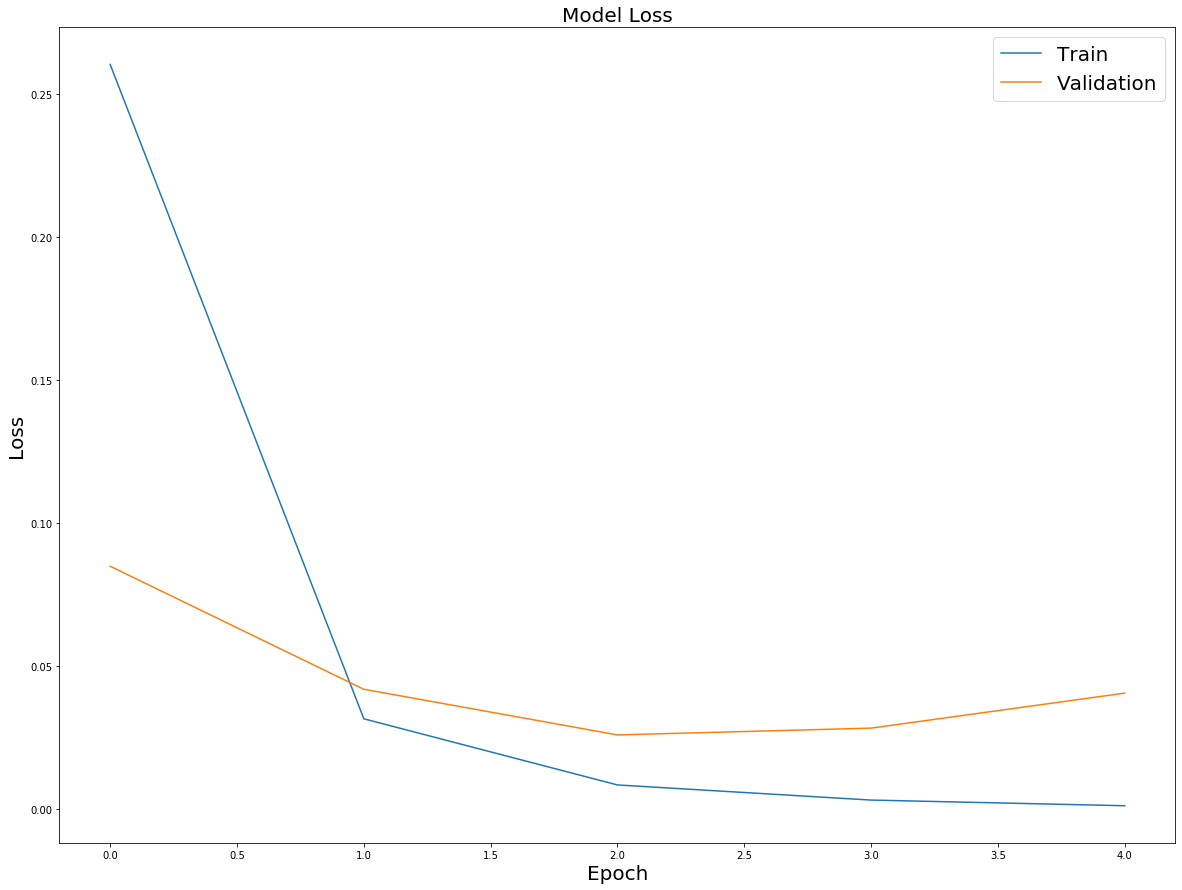

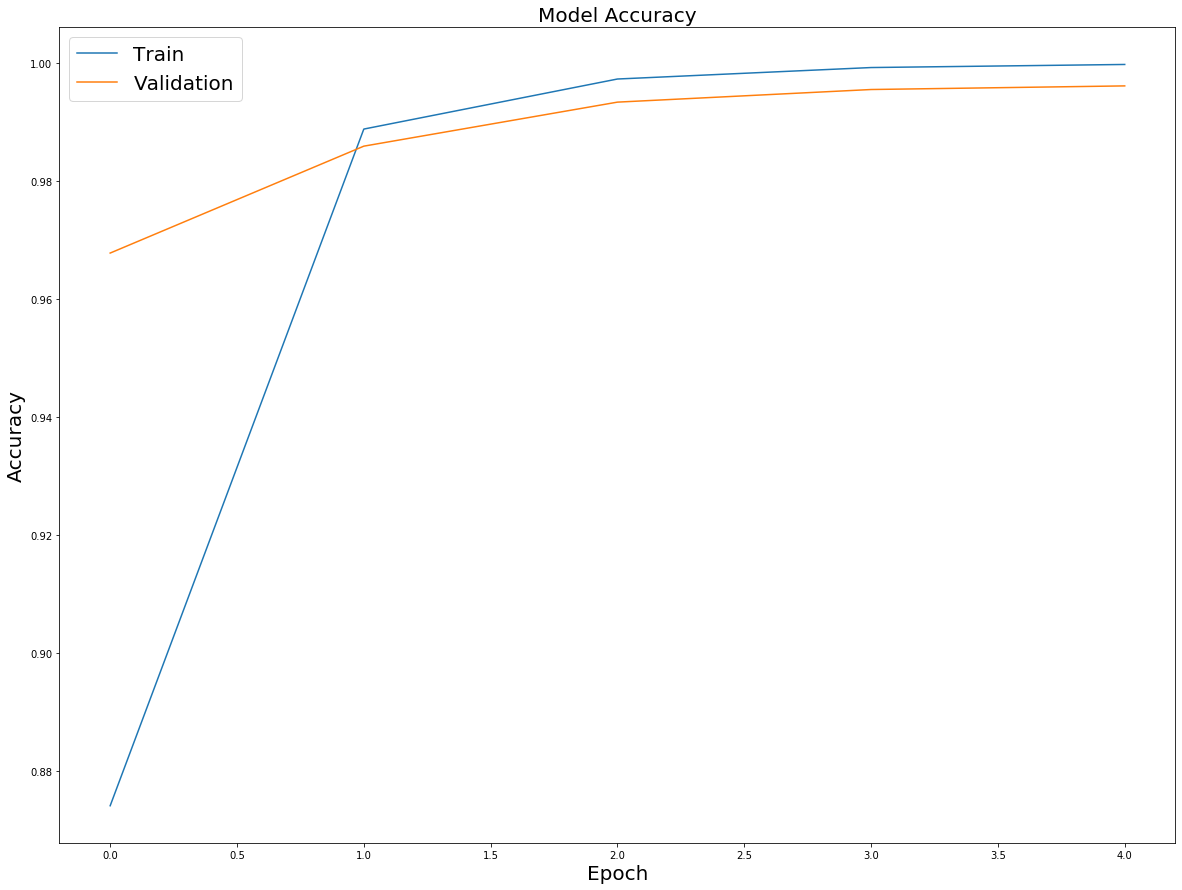

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[73141   217]
 [  347 73023]]


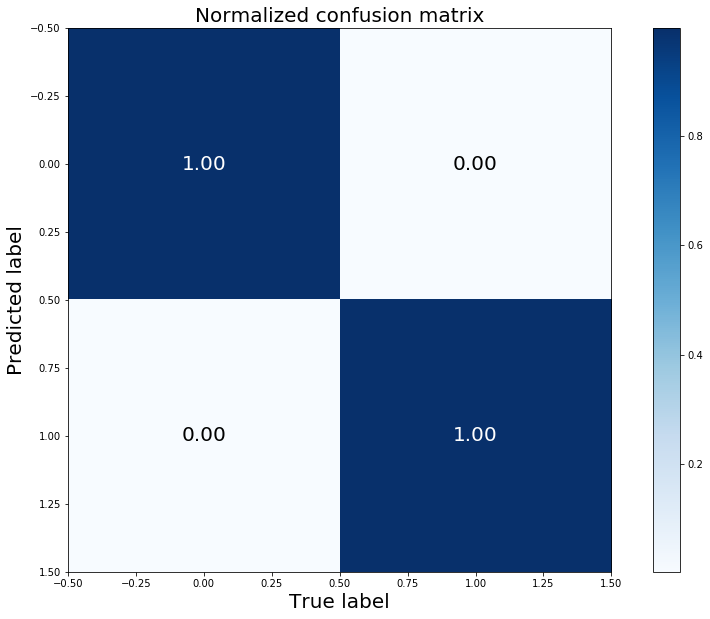

In [31]:
plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [32]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.62%


In [16]:
model.load_weights("LSTM.weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [17]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(944238, 10)


In [18]:
model = Sequential()
model.add(Embedding(vocab_size, 10))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.load_weights("LSTM.weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          9442380   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                1680      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________


In [19]:
X_test.shape

(146728, 191)

In [20]:
np.savetxt('X_test.txt', X_test)

In [21]:
X_test_read = np.int32(np.loadtxt('X_test.txt')).reshape((146728, 191))

In [22]:
X_test_orig = X_test

In [23]:
import random
j = 1
X_test_orig = np.int32(np.loadtxt('X_test.txt')).reshape((146728, 191))
X_test_perm = X_test_orig
X_test_perm[:,j] = random.sample(list(X_test_orig[:,j]), len(list(X_test_orig[:,j])))
X_test_perm[0:5, 0:5]

array([[298318,  56065, 222166,  71640, 114628],
       [392768, 384343, 531160, 508433, 289695],
       [ 82155, 548400, 129630, 147829, 168133],
       [ 36052,  90766, 180160, 333096, 468005],
       [ 96452, 411190,  58492, 456681,  46166]], dtype=int32)

In [24]:
scores = model.evaluate(X_test_perm, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.61%


In [25]:
perm_scores = []
for i in range(X_test.shape[1]):
    print(i)
    X_test_orig = np.int32(np.loadtxt('X_test.txt')).reshape((146728, 191))
    X_test_perm = X_test_orig
    X_test_perm[:,i] = random.sample(list(X_test[:,i]), len(list(X_test[:,i])))
    perm_scores.append(abs(model.evaluate(X_test_perm, y_test, verbose = 0)[1]*100 - 99.62))
    print(perm_scores)

0
[0.015971536636357087]
1
[0.015971536636357087, 0.010517711639408844]
2
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735]
3
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391]
4
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602]
5
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475]
6
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641]
7
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594]
8
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149]
28
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399]
40
[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

[0.015971536636357087, 0.010517711639408844, 0.013247604370121735, 0.009838218688969391, 0.005063886642460602, 0.0064288330078170475, 0.014606590271000641, 0.005749340057377594, 0.008473272323612946, 0.010517711639408844, 0.015292043685917633, 0.01665102958679654, 0.017336483001713532, 0.017336483001713532, 0.007108325958256501, 0.010517711639408844, 0.009838218688969391, 0.010517711639408844, 0.01665102958679654, 0.0064288330078170475, 0.0030194473266647037, 0.013247604370121735, 0.005749340057377594, 0.005063886642460602, 0.0023399543762252506, 0.003704900741581696, 0.0023399543762252506, 0.004384393692021149, 0.013927097320561188, 0.013247604370121735, 0.007108325958256501, 0.011197204589848297, 0.011197204589848297, 0.013927097320561188, 0.012562150955204743, 0.005749340057377594, 0.009152765274052399, 0.005749340057377594, 0.009838218688969391, 0.009152765274052399, 0.007108325958256501, 0.007793779373173493, 0.010517711639408844, 0.007793779373173493, 0.007108325958256501, 0.0091

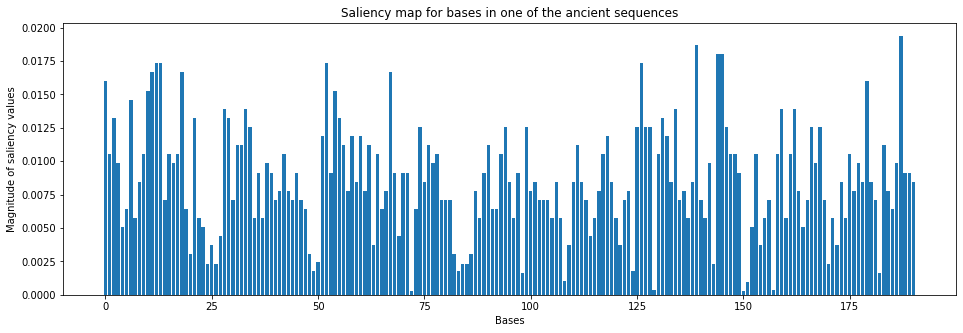

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(perm_scores)), perm_scores)
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
#plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the ancient sequences')
plt.show()

In [27]:
import pandas as pd
scores_df = pd.DataFrame({'Base': range(len(perm_scores)),'Score': perm_scores})
scores_df.to_csv('scores_df.txt', index = False, sep = '\t')
scores_df[scores_df['Score'] > 0.01]

,Base,Score
0,0,0.015972
1,1,0.010518
2,2,0.013248
6,6,0.014607
9,9,0.010518
...,...,...
168,168,0.012562
175,175,0.010518
179,179,0.015972
183,183,0.011197


In [28]:
informative_indeces = list(scores_df[scores_df['Score'] > 0.01].index)
informative_indeces

[0,
 1,
 2,
 6,
 9,
 10,
 11,
 12,
 13,
 15,
 17,
 18,
 21,
 28,
 29,
 31,
 32,
 33,
 34,
 42,
 51,
 52,
 54,
 55,
 56,
 58,
 60,
 62,
 64,
 67,
 74,
 76,
 78,
 90,
 93,
 94,
 99,
 111,
 117,
 118,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 134,
 139,
 144,
 145,
 146,
 147,
 148,
 153,
 158,
 159,
 161,
 162,
 166,
 168,
 175,
 179,
 183,
 187]

In [29]:
X_test[informative_indeces, 0:5]

array([[298318, 334207, 222166,  71640, 114628],
       [392768, 465682, 531160, 508433, 289695],
       [ 82155, 147585, 129630, 147829, 168133],
       [ 33814, 132267, 246793,  57224, 423945],
       [ 34264,  29477, 103648, 199918, 205200],
       [121740, 152396,  68773,  25577,   7491],
       [199624, 138345,  82166, 251793, 466560],
       [171944, 115206,  85550, 103892,  40506],
       [352878, 289909,  65309,  30183,   7073],
       [  6156,   6214,  18132,  32384,  73078],
       [411825, 316889, 376700, 283617, 148563],
       [277097, 285648, 428785, 299544,  33257],
       [781556, 620964, 567133, 599093, 581992],
       [366228, 632405, 368385, 208563, 389839],
       [517171, 332139, 318824, 259603, 192078],
       [331953,  70804, 270081, 503961, 554606],
       [615117, 596618, 760965, 809886, 670269],
       [ 63182, 156984, 123211, 225019, 107900],
       [ 53346,  19988,  31979,  41229,  12532],
       [  3404,   6979,  30874,  22115,   4252],
       [   433,    4

In [30]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    return [reverse_word_map.get(letter) for letter in list_of_indices]
my_texts = list(map(sequence_to_text, X_test[informative_indeces, :]))
my_texts[0][0:5]

['gccatggggc', 'ccatggggct', 'catggggctg', 'atggggctgg', 'tggggctggc']

In [31]:
len([item for sublist in my_texts for item in sublist])

12415

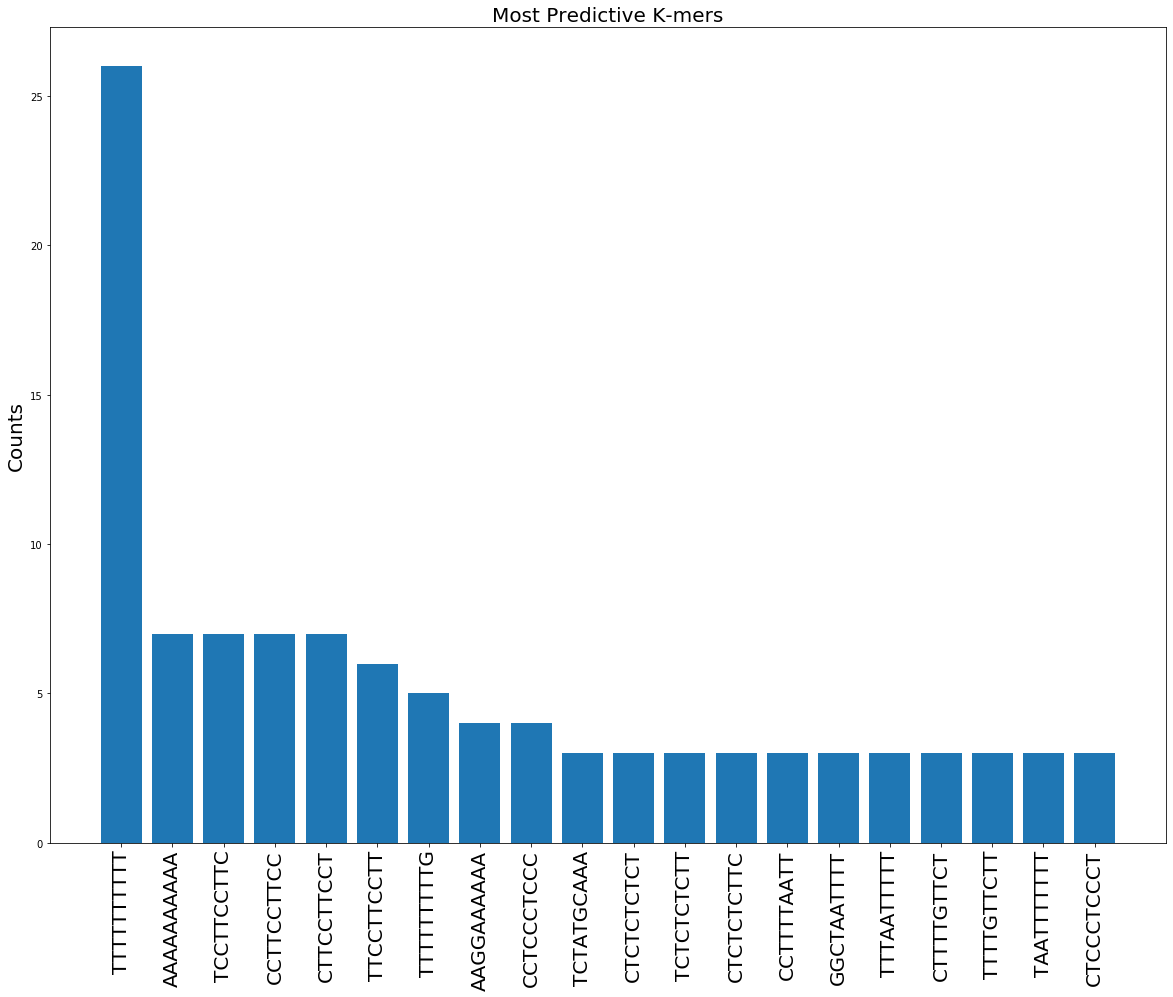

In [32]:
from collections import Counter
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 15))

D = dict(Counter([item.upper() for sublist in my_texts for item in sublist]).most_common(20))
plt.bar(range(len(D)), list(D.values()), align = 'center')
plt.title('Most Predictive K-mers', fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.xticks(rotation = 90)
plt.xticks(range(len(D)), list(D.keys()), fontsize = 20)
plt.show()

# CNN

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation

import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = max_length))
model.add(Conv1D(filters = 16, kernel_size = 5, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

epochs = 50
lrate = 0.0001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, nesterov = False)
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 191, 10)           9442380   
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 16)           816       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1488)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1489      
Total params: 9,444,685
Trainable params: 9,444,685
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 469529 samples, validate on 117383 samples
Epoch 1/50
469504/469529 [============================>.] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.5012
Epoch 00001: val_binary_accuracy improved from -inf to 0.50248, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 115s 244us/sample - loss: 0.6932 - binary_accuracy: 0.5012 - val_loss: 0.6932 - val_binary_accuracy: 0.5025
Epoch 2/50
469216/469529 [============================>.] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.5030
Epoch 00002: val_binary_accuracy improved from 0.50248 to 0.50299, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 108s 229us/sample - loss: 0.6931 - binary_accuracy: 0.5030 - val_loss: 0.6931 - val_binary_accuracy: 0.5030
Epoch 3/50
469312/469529 [============================>.] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.5047
Epoch 00003: val_binary_accuracy improved from 0.50299 to 0.50520, saving 

469529/469529 [==============================] - 115s 246us/sample - loss: 0.6920 - binary_accuracy: 0.5327 - val_loss: 0.6923 - val_binary_accuracy: 0.5266
Epoch 23/50
469472/469529 [============================>.] - ETA: 0s - loss: 0.6920 - binary_accuracy: 0.5339
Epoch 00023: val_binary_accuracy did not improve from 0.52663
469529/469529 [==============================] - 134s 285us/sample - loss: 0.6920 - binary_accuracy: 0.5339 - val_loss: 0.6923 - val_binary_accuracy: 0.5247
Epoch 24/50
469472/469529 [============================>.] - ETA: 0s - loss: 0.6919 - binary_accuracy: 0.5353
Epoch 00024: val_binary_accuracy improved from 0.52663 to 0.52873, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 118s 252us/sample - loss: 0.6919 - binary_accuracy: 0.5353 - val_loss: 0.6922 - val_binary_accuracy: 0.5287
Epoch 25/50
469376/469529 [============================>.] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5380
Epoch 00025: val_bi

Epoch 45/50
469408/469529 [============================>.] - ETA: 0s - loss: 0.6866 - binary_accuracy: 0.5816
Epoch 00045: val_binary_accuracy improved from 0.57283 to 0.57674, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 117s 249us/sample - loss: 0.6866 - binary_accuracy: 0.5816 - val_loss: 0.6873 - val_binary_accuracy: 0.5767
Epoch 46/50
469408/469529 [============================>.] - ETA: 0s - loss: 0.6859 - binary_accuracy: 0.5850
Epoch 00046: val_binary_accuracy did not improve from 0.57674
469529/469529 [==============================] - 111s 236us/sample - loss: 0.6859 - binary_accuracy: 0.5850 - val_loss: 0.6865 - val_binary_accuracy: 0.5757
Epoch 47/50
469408/469529 [============================>.] - ETA: 0s - loss: 0.6850 - binary_accuracy: 0.5877
Epoch 00047: val_binary_accuracy improved from 0.57674 to 0.58278, saving model to /home/ubuntu/Ragu/weights.cnn.hdf5
469529/469529 [==============================] - 119s 253u

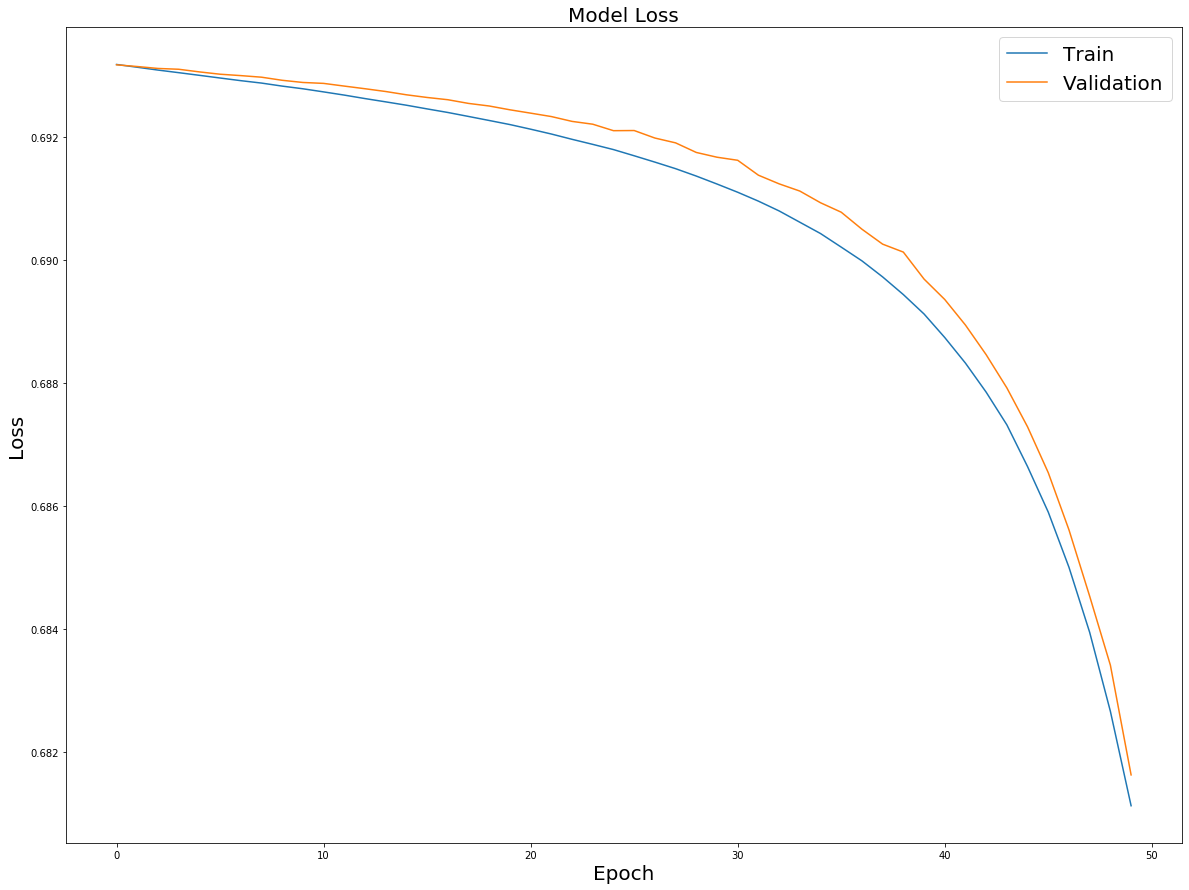

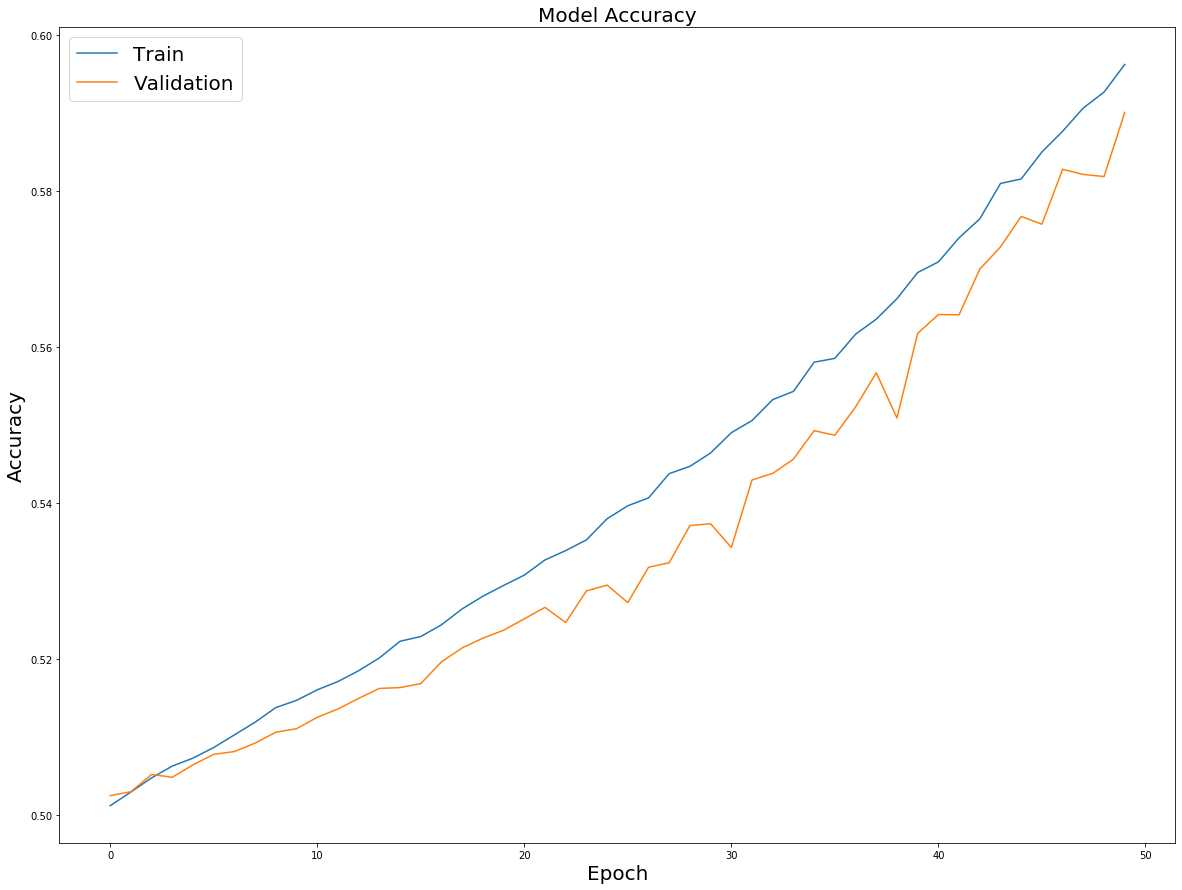

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[46016 27342]
 [32819 40551]]


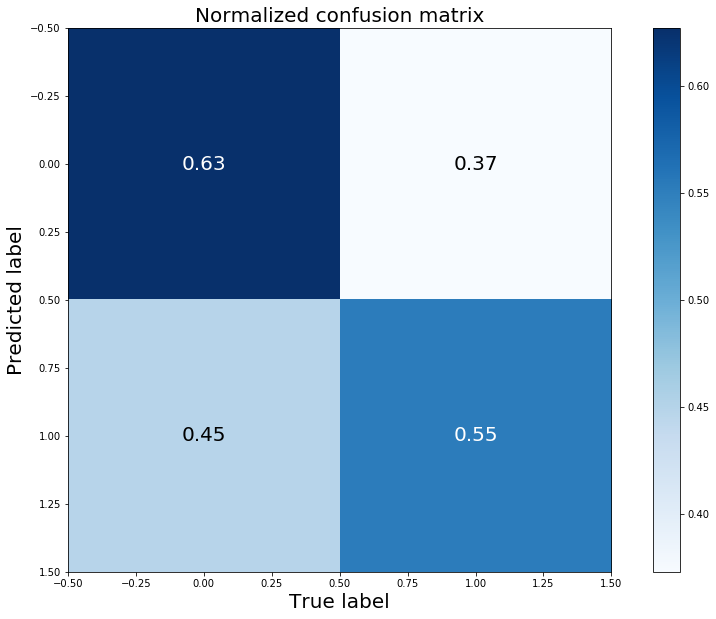

In [54]:
plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [55]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 59.00%


# RNN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 10))
model.add(Bidirectional(SimpleRNN(10)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          9442380   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                420       
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,443,021
Trainable params: 9,443,021
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True)

Train on 469529 samples, validate on 117383 samples
Epoch 1/5
469529/469529 [==============================] - 4789s 10ms/sample - loss: 0.3284 - accuracy: 0.8374 - val_loss: 0.1087 - val_accuracy: 0.9587
Epoch 2/5
469529/469529 [==============================] - 4742s 10ms/sample - loss: 0.0399 - accuracy: 0.9862 - val_loss: 0.0395 - val_accuracy: 0.9868
Epoch 3/5
469529/469529 [==============================] - 4738s 10ms/sample - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0282 - val_accuracy: 0.9920
Epoch 4/5
469529/469529 [==============================] - 4765s 10ms/sample - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.1665 - val_accuracy: 0.9668
Epoch 5/5
469529/469529 [==============================] - 4847s 10ms/sample - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0356 - val_accuracy: 0.9945


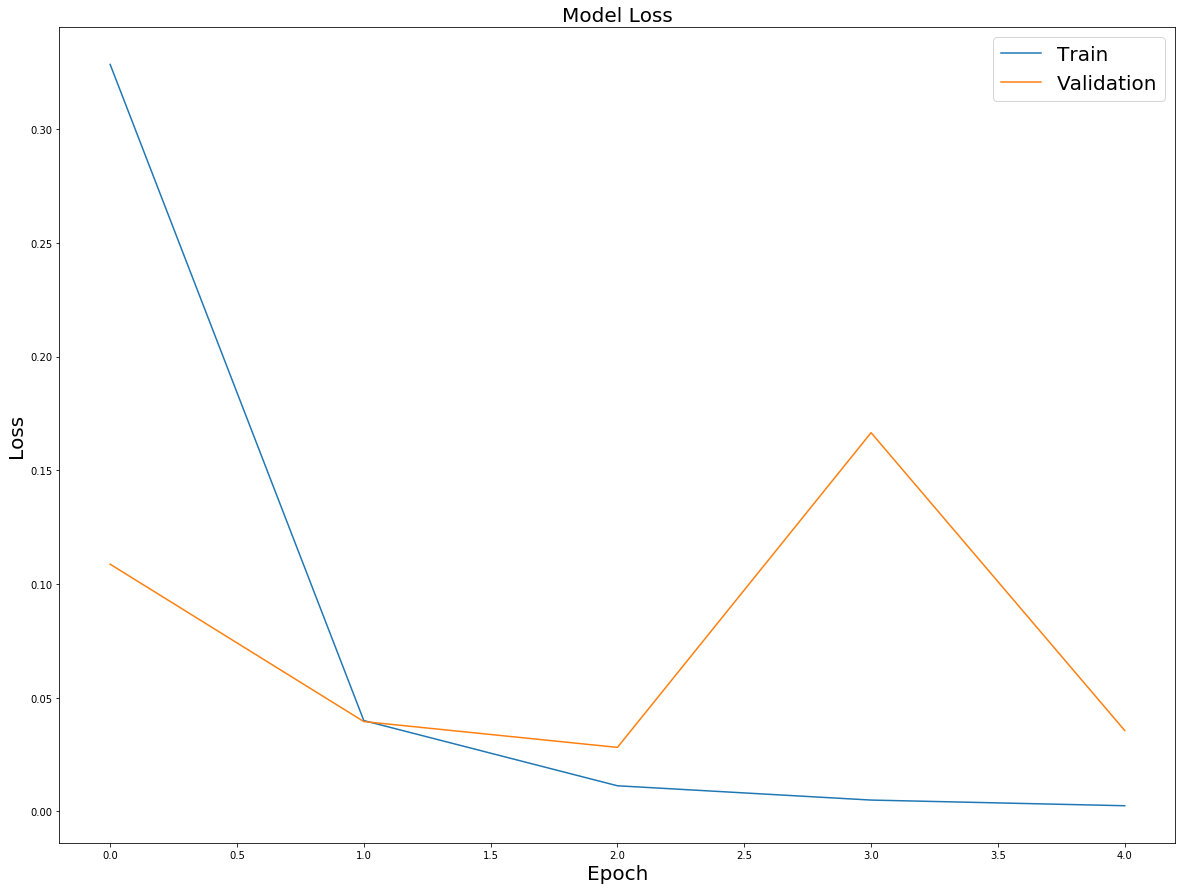

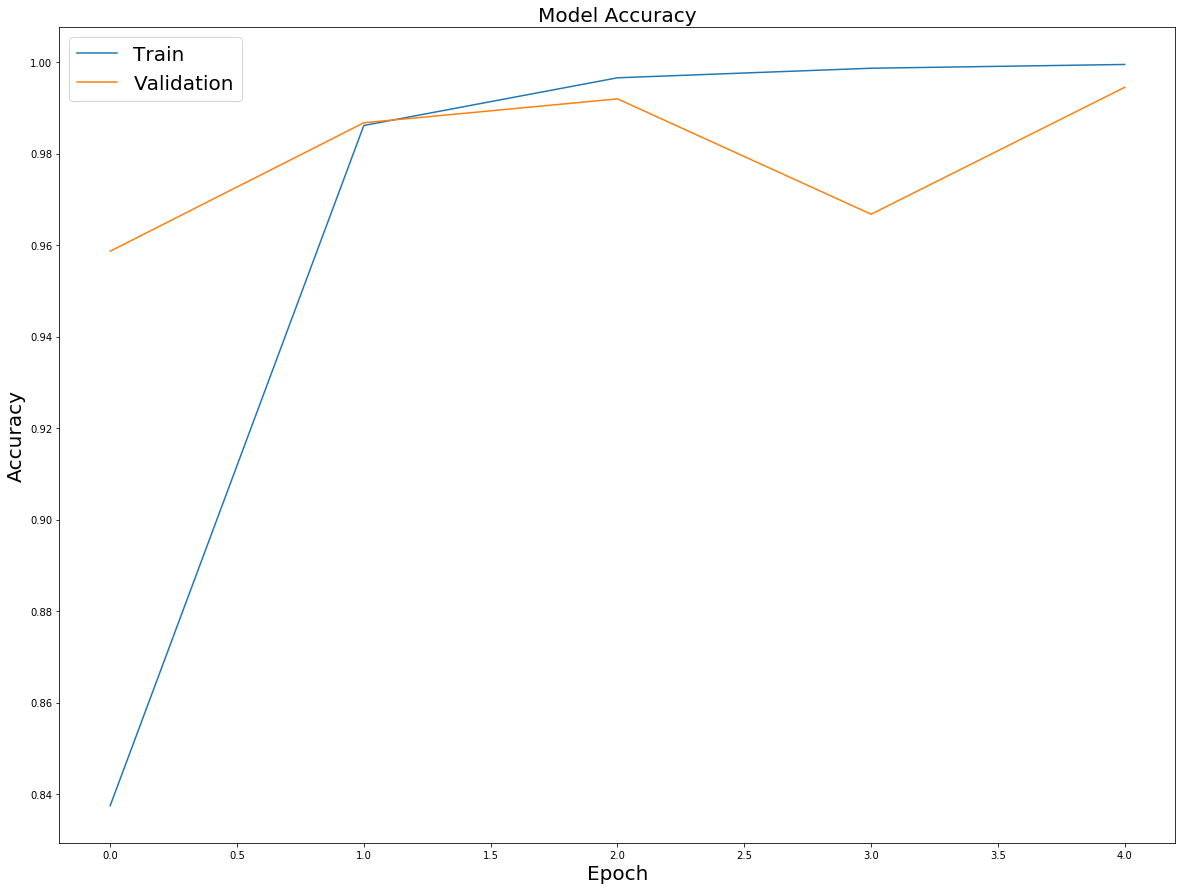

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [18]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Confusion matrix:
 [[73030   328]
 [  519 72851]]


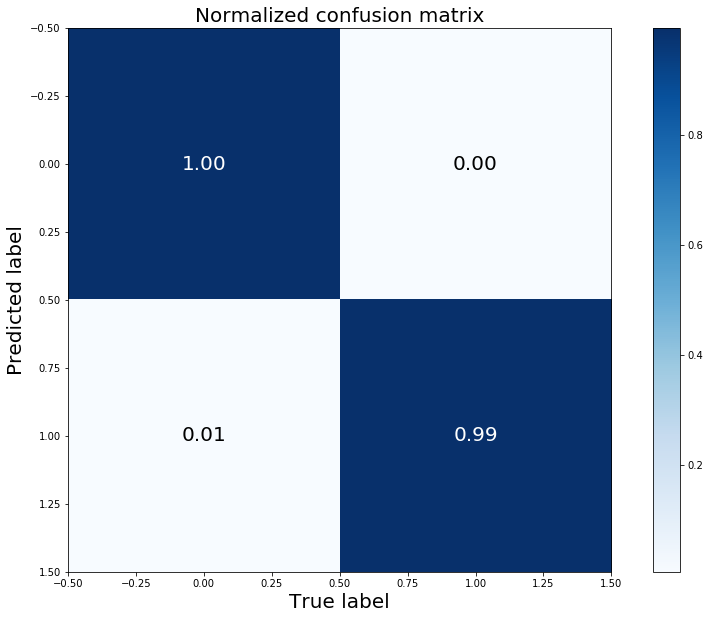

In [19]:
plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [20]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.42%


## Neanderthal genes prediction

In [21]:
from Bio import SeqIO

gene_file = 'hg19_gene_clean.fa'

e = 0
gene_seqs = []
gene_ids = []
for gene in SeqIO.parse('/home/ubuntu/data/' + gene_file, 
                        'fasta'):
    
    cutoff = 200
    if len(str(gene.seq)) < cutoff:
        continue

    gene_ids.append(str(gene.id))
    s_gene = str(gene.seq)[0:cutoff]
    gene_seqs.append(s_gene)

    e = e + 1
    if e%10000 == 0:
        print('Finished ' + str(e) + ' genes')

def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 10
gene_texts = [' '.join(getKmers(i, kmer)) for i in gene_seqs]

Finished 10000 genes
Finished 20000 genes
Finished 30000 genes


In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(gene_texts)

encoded_docs = tokenizer.texts_to_sequences(gene_texts)
max_length = max([len(s.split()) for s in gene_texts])
X_gene = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X_gene)
print('\n')
print(X_gene.shape)

Using TensorFlow backend.


[[547859 642875 642876 ... 125875 110809  77277]
 [253351 294309 164774 ...  31487 125876 218639]
 [164781  61751 110810 ... 253371 218650 294330]
 ...
 [300782 349547 453994 ...  14457  10644  10929]
 [ 63780 142785 252925 ...  53054 543738 324349]
 [273128 360570 109937 ... 219163  82309 120347]]


(35549, 191)


In [23]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

891013


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation, Bidirectional

model = Sequential()
model.add(Embedding(944238, 10))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.load_weights("LSTM.weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          9442380   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                1680      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________


In [25]:
gene_predictions = model.predict_classes(X_gene)
gene_predictions_prob = model.predict_proba(X_gene)

In [26]:
X_gene.shape

(35549, 191)

In [27]:
gene_predictions.shape

(35549, 1)

In [28]:
gene_predictions_prob.shape

(35549, 1)

In [29]:
with open('gene_ids_LSTM.txt', 'w') as f:
    for item in gene_ids:
        f.write("%s\n" % item)

In [30]:
"""gene_ids = []
gene_symbol = []
with open('gene_ids_LSTM.txt','r') as fin:
    for line in fin:
        line = line.split('\t')
        gene_ids.append(line[0])
        gene_symbol.append(line[1].rstrip())"""

"gene_ids = []\ngene_symbol = []\nwith open('gene_ids_LSTM.txt','r') as fin:\n    for line in fin:\n        line = line.split('\t')\n        gene_ids.append(line[0])\n        gene_symbol.append(line[1].rstrip())"

In [31]:
import pandas as pd
gene_pred_df = pd.DataFrame({'Gene': gene_ids, 
                             'Predict': list(gene_predictions.flatten()), 
                             'Prob': list(gene_predictions_prob.flatten())})
gene_pred_df = gene_pred_df.sort_values(['Prob'], ascending = False)
gene_pred_df[(gene_pred_df['Predict'] == 1) & (gene_pred_df['Prob'] > 0.8)]

,Gene,Predict,Prob
6191,chr11:89657232-89666229,1,1.000000
18041,chr2:190628585-190648719,1,1.000000
14403,chr19:1952526-1954548,1,1.000000
26601,chr6:35762759-35765100,1,1.000000
875,chr1:45097640-45117395,1,1.000000
...,...,...,...
7060,chr12:11090853-11091806,1,0.802003
34681,chrX:101967376-102008468,1,0.801439
34679,chrX:101967376-101972661,1,0.801439
34680,chrX:101967376-101979789,1,0.801439


In [32]:
gene_pred_df.to_csv('Neanderthal_Genes_LSTM.txt', index = False, sep = '\t')